In [1]:
#!pip install tensorflow tensorflow_hub

# dog vs cat with transfer learning

## dependencies

In [2]:
from zipfile import ZipFile
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import glob
import cv2
import tensorflow as tf
import tensorflow_hub as hub

## dataset

In [3]:
# configuration
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# downloading the dataset
!kaggle competitions download -c dogs-vs-cats

 97% 789M/812M [00:05<00:00, 91.4MB/s]
100% 812M/812M [00:05<00:00, 164MB/s] 


In [5]:
!ls

dogs-vs-cats.zip  kaggle.json  sample_data


In [6]:
# extracting the entire dataset
ds = "/content/dogs-vs-cats.zip"

with ZipFile(ds, "r") as zip:
  zip.extractall()
  print("extraction complete...............")

extraction complete...............


In [7]:
# extracting the entire dataset
trainds = "/content/train.zip"

with ZipFile(trainds, "r") as zip:
  zip.extractall()
  print("extraction complete...............")

extraction complete...............


In [8]:
path, dirs, files = next(os.walk("/content/train"))
file_count = len(files)
print("number of images:", file_count)

number of images: 25000


## dataset exploration

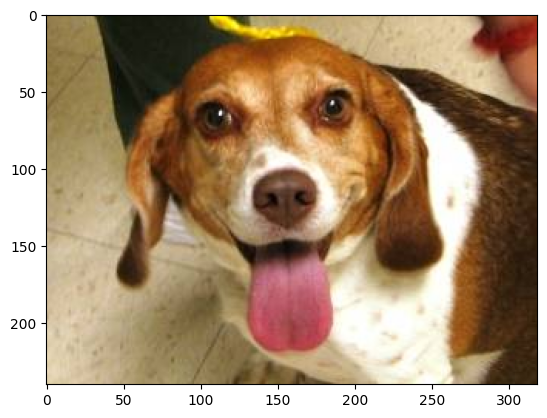

In [9]:
# displaying dog image
img = mpimg.imread("/content/train/dog.12365.jpg")
img_plt = plt.imshow(img)
plt.show()


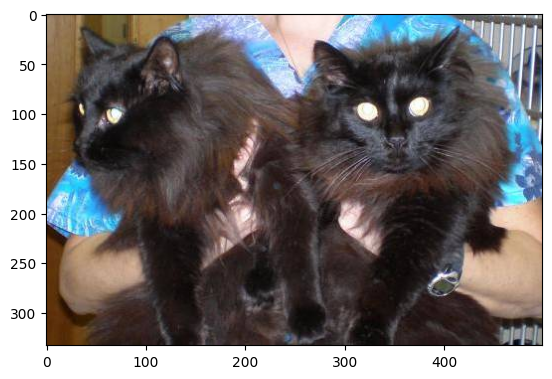

In [10]:
# displaying dog image
img = mpimg.imread("/content/train/cat.960.jpg")
img_plt = plt.imshow(img)
plt.show()

## images preprocessing

In [11]:
file_names = os.listdir("/content/train/")

for i in range(5):
  name = file_names[i]
  print(name[:3])

cat
cat
cat
cat
cat


In [12]:
file_names = os.listdir("/content/train/")
dog_count = 0
cat_count = 0

for img_file in file_names:
  name = img_file[0:3]
  if name == "dog":
    dog_count += 1
  else:
    cat_count += 1
print("dogs: ", dog_count)
print("cats: ", cat_count)

dogs:  12500
cats:  12500


In [13]:
# directory for resized images
os.mkdir("/content/image_resized")

In [14]:
original_folder = "/content/train/"
resized_folder = "/content/image_resized/"

# 2000 images only
for i in range(2000):
  filename = os.listdir(original_folder)[i]
  img_path = original_folder+filename

  img = Image.open(img_path)
  img = img.resize((224, 224))
  img = img.convert("RGB")

  newImgPath = resized_folder+filename
  img.save(newImgPath)

In [15]:
file_names = os.listdir('/content/image_resized/')
print(file_names)

['cat.130.jpg', 'cat.3717.jpg', 'cat.6518.jpg', 'cat.9716.jpg', 'cat.8746.jpg', 'cat.10073.jpg', 'cat.4420.jpg', 'dog.3225.jpg', 'cat.7851.jpg', 'cat.6475.jpg', 'dog.5551.jpg', 'dog.2170.jpg', 'cat.7575.jpg', 'dog.10162.jpg', 'dog.2391.jpg', 'cat.2272.jpg', 'cat.12069.jpg', 'dog.6628.jpg', 'cat.3719.jpg', 'dog.3434.jpg', 'dog.3696.jpg', 'cat.8046.jpg', 'dog.348.jpg', 'cat.11990.jpg', 'cat.2405.jpg', 'dog.2617.jpg', 'cat.2045.jpg', 'dog.419.jpg', 'dog.329.jpg', 'dog.1945.jpg', 'cat.6791.jpg', 'dog.7004.jpg', 'dog.5132.jpg', 'cat.8950.jpg', 'dog.11455.jpg', 'dog.7347.jpg', 'cat.10044.jpg', 'cat.9447.jpg', 'cat.7002.jpg', 'dog.1053.jpg', 'cat.7660.jpg', 'cat.9192.jpg', 'cat.2059.jpg', 'cat.10919.jpg', 'cat.1369.jpg', 'dog.2222.jpg', 'dog.7282.jpg', 'dog.4434.jpg', 'cat.5669.jpg', 'dog.436.jpg', 'dog.6785.jpg', 'cat.2225.jpg', 'cat.12253.jpg', 'dog.506.jpg', 'dog.4910.jpg', 'dog.3777.jpg', 'dog.11682.jpg', 'dog.7813.jpg', 'cat.3065.jpg', 'cat.7892.jpg', 'cat.8018.jpg', 'dog.523.jpg', 'dog.

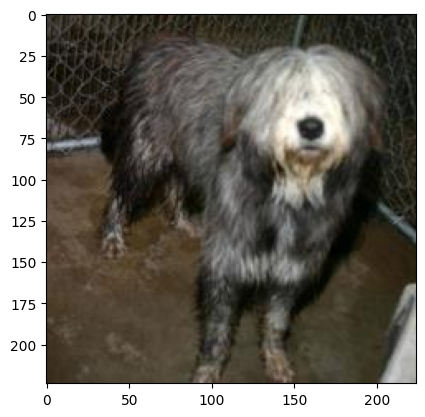

In [16]:
# displaying dog resized image
img = mpimg.imread("/content/image_resized/dog.3225.jpg")
img_plt = plt.imshow(img)
plt.show()

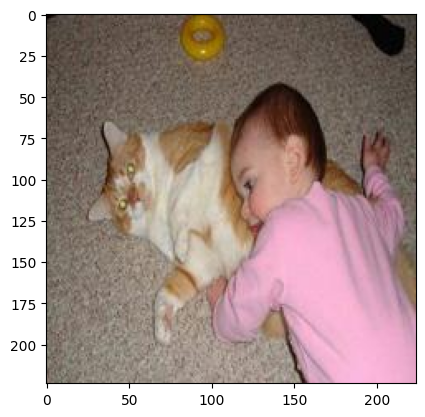

In [17]:
# displaying cat resized image
img = mpimg.imread("/content/image_resized/cat.9716.jpg")
img_plt = plt.imshow(img)
plt.show()

In [18]:
# assigning labels (cat --> 0, dog --> 1)
file_names = os.listdir("/content/image_resized/")
labels = []

for i in range(2000):
  file_name = file_names[i]
  label = file_name[0:3]

  if label == "dog":
    labels.append(1)
  else:
    labels.append(0)


In [19]:
print(len(labels[:10]))
print(labels[:10])

10
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


In [20]:
# images distribution in the sample
values, counts = np.unique(labels, return_counts=True)
print(values)
print(counts)

[0 1]
[1033  967]


In [21]:
# to np arrays
image_directory = "/content/image_resized/"
image_extension = ["png", "jpg"]

files = []
[files.extend(glob.glob(image_directory + "*." + e)) for e in image_extension]
dog_cat_images = np.asarray([cv2.imread(file) for file in files])

In [22]:
print(dog_cat_images.shape)

(2000, 224, 224, 3)


## features and labels selection, modelling, and training

In [23]:
# images and labels
X, y = dog_cat_images, np.asarray(labels)
y.shape

(2000,)

In [24]:
# training and testing splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 21
)
print(X.shape, X_train.shape, X_test.shape)

(2000, 224, 224, 3) (1600, 224, 224, 3) (400, 224, 224, 3)


In [25]:
# scaling the images
X_train_scaled = X_train/255
X_test_scaled = X_test/255

### transfer learning modelling --> mobilenetv2

In [26]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
    pooling="avg"
)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [27]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(2)
])

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ["acc"]
)

In [30]:
history = model.fit(
    X_train_scaled,
    y_train,
    epochs = 5
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - acc: 0.8813 - loss: 0.2768
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - acc: 0.9791 - loss: 0.0637
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - acc: 0.9821 - loss: 0.0547
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - acc: 0.9888 - loss: 0.0401
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - acc: 0.9930 - loss: 0.0300


In [31]:
# evaluation
score, acc = model.evaluate(X_test_scaled, y_test)
print(f"test loss {score}")
print(f"test accuracy {acc}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 869ms/step - acc: 0.9746 - loss: 0.0888
test loss 0.0876411646604538
test accuracy 0.9750000238418579


## test system

path of the image to be predicted: /content/test_images/cat.jpeg


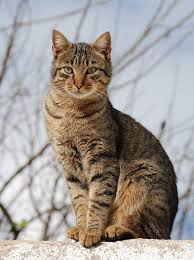

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
the image is a cat


In [43]:
# simple predictive system
input_image_path = input("path of the image to be predicted: ")
input_image = cv2.imread(input_image_path)
cv2_imshow(input_image)
input_image_resize = cv2.resize(input_image, (224, 224))
input_image_scaled = input_image_resize/255
image_reshaped = np.reshape(input_image_scaled, [1, 224, 224, 3])
input_prediction = model.predict(image_reshaped)
input_pred_label = np.argmax(input_prediction)

if input_pred_label == 0:
  print("the image is a cat")
else:
  print("the image is a dog")

## saving the model


In [44]:
import pickle

class_names = ["cat", "dog"]
model.save("dog_cat_classifier.keras")
with open("class_names.pkl", "wb") as f:
    pickle.dump(class_names, f)

print("Model and class names saved.")


Model and class names saved.


# modelling complete